In this section we will be building more complex pipelines using mixed type columnar data. On the way, we will build custom encoders in sci-kit learn and a pipeline comprising all features and their preprocessing steps.  

The Speed dating dataset accompanied the book *Data Analysis Using Regression and Multilevel/Hierarchical Models* by Andrew Gelman and Jennifer Hill. They used the examples to show applications for regressions within a Bayesian framework. The main technique covered was Bayesian inference using Gibbs Sampling, a technique that is now considered to be largely obsolete. We will use a different technique here, and we will have fun explaining some mechanics of human mate choices. You can find out more information [about this dataset at OpenML](https://www.openml.org/d/40536).


The dataset is available at openML.

In [4]:
pip install -q openml

     |████████████████████████████████| 163kB 2.8MB/s 


In [0]:
import openml
openml.config.apikey = 'e6b9a1a80b1e0c3bbd40f5dbf5943fb9'
openml.config.server = 'https://www.openml.org/api/v1/xml' 

dataset = openml.datasets.get_dataset(40536)

In [0]:
X, y, categorical_indicator, _ = dataset.get_data(
    dataset_format='dataframe',
    target=dataset.default_target_attribute
)
categorical_features = X.columns[categorical_indicator]

In [7]:
X.head()

,has_null,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,importance_same_race,importance_same_religion,d_importance_same_race,d_importance_same_religion,field,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,d_pref_o_attractive,d_pref_o_sincere,d_pref_o_intelligence,d_pref_o_funny,d_pref_o_ambitious,d_pref_o_shared_interests,attractive_o,sinsere_o,intelligence_o,funny_o,ambitous_o,shared_interests_o,d_attractive_o,d_sinsere_o,d_intelligence_o,d_funny_o,d_ambitous_o,d_shared_interests_o,attractive_important,...,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,d_sports,d_tvsports,d_exercise,d_dining,d_museums,d_art,d_hiking,d_gaming,d_clubbing,d_reading,d_tv,d_theater,d_movies,d_concerts,d_music,d_shopping,d_yoga,interests_correlate,d_interests_correlate,expected_happy_with_sd_people,expected_num_interested_in_me,expected_num_matches,d_expected_happy_with_sd_people,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met
0,0,1.0,female,21.0,27.0,6.0,[4-6],Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,2.0,4.0,[2-5],[2-5],Law,35.0,20.0,20.0,20.0,0.0,5.0,[21-100],[16-20],[16-20],[16-20],[0-15],[0-15],6.0,8.0,8.0,8.0,8.0,6.0,[6-8],[6-8],[6-8],[6-8],[6-8],[6-8],15.0,...,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,[9-10],[0-5],[6-8],[9-10],[0-5],[0-5],[0-5],[0-5],[0-5],[6-8],[9-10],[0-5],[9-10],[9-10],[9-10],[6-8],[0-5],0.14,[0-0.33],3.0,2.0,4.0,[0-4],[0-3],[3-5],7.0,6.0,[6-8],[5-6],0.0
1,0,1.0,female,21.0,22.0,1.0,[0-1],Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,2.0,4.0,[2-5],[2-5],Law,60.0,0.0,0.0,40.0,0.0,0.0,[21-100],[0-15],[0-15],[21-100],[0-15],[0-15],7.0,8.0,10.0,7.0,7.0,5.0,[6-8],[6-8],[9-10],[6-8],[6-8],[0-5],15.0,...,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,[9-10],[0-5],[6-8],[9-10],[0-5],[0-5],[0-5],[0-5],[0-5],[6-8],[9-10],[0-5],[9-10],[9-10],[9-10],[6-8],[0-5],0.54,[0.33-1],3.0,2.0,4.0,[0-4],[0-3],[3-5],7.0,5.0,[6-8],[5-6],1.0
2,1,1.0,female,21.0,22.0,1.0,[0-1],Asian/Pacific Islander/Asian-American,Asian/Pacific Islander/Asian-American,1,2.0,4.0,[2-5],[2-5],Law,19.0,18.0,19.0,18.0,14.0,12.0,[16-20],[16-20],[16-20],[16-20],[0-15],[0-15],10.0,10.0,10.0,10.0,10.0,10.0,[9-10],[9-10],[9-10],[9-10],[9-10],[9-10],15.0,...,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,[9-10],[0-5],[6-8],[9-10],[0-5],[0-5],[0-5],[0-5],[0-5],[6-8],[9-10],[0-5],[9-10],[9-10],[9-10],[6-8],[0-5],0.16,[0-0.33],3.0,2.0,4.0,[0-4],[0-3],[3-5],7.0,NaN,[6-8],[0-4],1.0
3,0,1.0,female,21.0,23.0,2.0,[2-3],Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,2.0,4.0,[2-5],[2-5],Law,30.0,5.0,15.0,40.0,5.0,5.0,[21-100],[0-15],[0-15],[21-100],[0-15],[0-15],7.0,8.0,9.0,8.0,9.0,8.0,[6-8],[6-8],[9-10],[6-8],[9-10],[6-8],15.0,...,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,[9-10],[0-5],[6-8],[9-10],[0-5],[0-5],[0-5],[0-5],[0-5],[6-8],[9-10],[0-5],[9-10],[9-10],[9-10],[6-8],[0-5],0.61,[0.33-1],3.0,2.0,4.0,[0-4],[0-3],[3-5],7.0,6.0,[6-8],[5-6],0.0
4,0,1.0,female,21.0,24.0,3.0,[2-3],Asian/Pacific Islander/Asian-American,Latino/Hispanic American,0,2.0,4.0,[2-5],[2-5],Law,30.0,10.0,20.0,10.0,10.0,20.0,[21-100],[0-15],[16-20],[0-15],[0-15],[16-20],8.0,7.0,9.0,6.0,9.0,7.0,[6-8],[6-8],[9-10],[6-8],[9-10],[6-8],15.0,...,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,[9-10],[0-5],[6-8],[9-10],[0-5],[0-5],[0-5],[0-5],[0-5],[6-8],[9-10],[0-5],[9-10],[9-10],[9-10],[6-8],[0-5],0.21,[0-0.33],3.0,2.0,4.0,[0-4],[0-3],[3-5],6.0,6.0,[6-8],[5-6],0.0


A few things come up pretty quickly looking at this dataset. We have a lot of categorical features. So for modeling, we will need to encode them numerically. Some of these are actually encoded ranges. We will have to encode them specifically. More for exercise and illustration than for practical purpose, we are going to implement a transformer to plug into a sklearn pipeline in order to convert these range features to numeric features.

In [8]:
example_ranges = X['d_interests_correlate'].unique()
example_ranges

[[0-0.33], [0.33-1], [-1-0]]
Categories (3, object): [[0-0.33] < [0.33-1] < [-1-0]]

We can parse the ranges pretty easily in a function taking the lower and upper limit. And later on, we can then convert the ranges to something else, for example taking the mean of the range.

In [0]:
def encode_ranges(range_str):
  splits = range_str[1:-1].split('-')
  range_max = splits[-1]
  range_min = '-'.join(splits[:-1])
  return range_min, range_max

Let us try encoding these example ranges.


In [10]:
[encode_ranges(r) for r in example_ranges]

[('0', '0.33'), ('0.33', '1'), ('-1', '0')]

In [11]:
range_features = [
                  col for col in X.select_dtypes(include='category')
                  if X[col].apply(lambda x: x.startswith('[')
                  if isinstance(x, str) else False).any()
]

import pprint
pprint.pprint(range_features)

['d_d_age',
 'd_importance_same_race',
 'd_importance_same_religion',
 'd_pref_o_attractive',
 'd_pref_o_sincere',
 'd_pref_o_intelligence',
 'd_pref_o_funny',
 'd_pref_o_ambitious',
 'd_pref_o_shared_interests',
 'd_attractive_o',
 'd_sinsere_o',
 'd_intelligence_o',
 'd_funny_o',
 'd_ambitous_o',
 'd_shared_interests_o',
 'd_attractive_important',
 'd_sincere_important',
 'd_intellicence_important',
 'd_funny_important',
 'd_ambtition_important',
 'd_shared_interests_important',
 'd_attractive',
 'd_sincere',
 'd_intelligence',
 'd_funny',
 'd_ambition',
 'd_attractive_partner',
 'd_sincere_partner',
 'd_intelligence_partner',
 'd_funny_partner',
 'd_ambition_partner',
 'd_shared_interests_partner',
 'd_sports',
 'd_tvsports',
 'd_exercise',
 'd_dining',
 'd_museums',
 'd_art',
 'd_hiking',
 'd_gaming',
 'd_clubbing',
 'd_reading',
 'd_tv',
 'd_theater',
 'd_movies',
 'd_concerts',
 'd_music',
 'd_shopping',
 'd_yoga',
 'd_interests_correlate',
 'd_expected_happy_with_sd_people',
 'd

But first, since we plan to make this preprocessing replicable in order to submit it to the competition, we will have to rewrite our preprocessing function as a scikit-learn transformer.

Later on, we are going to submit this model to the OpenML competition dedicated to this dataset. OpenML is an organization that intends to make data science and machine learning more replicable and therefore more conducive to open research. Not only results are shown, but also the models are transparent. Therefore, during submission, you will have to use publicly available modules. This means that we had to create a module and publish it in the pypi python package repository. Here is the basic code for the RangeTransformer.

```python
from sklearn.base import BaseEstimator, TransformerMixin


class RangeTransformer(BaseEstimator, TransformerMixin):
    '''
    A custom transformer for ranges.

    Parameters
    ----------
    range_features : list[str]
        This specifies the column names with the ranges. 

    Attributes
    ----------
    range_features : list[str]
        Here we store the columns with range features.
    suffix : this determines how we will rename the transformed features.
    '''
    def __init__(self, range_features=[], suffix='_range/mean'):
        assert isinstance(range_features, list)
        self.range_features = range_features
        self.suffix = suffix
    
    def fit(self, X, y=None):
        '''Nothing to do here
        '''
        return self
    
    def transform(self, X, y=None):
        range_data = pd.DataFrame()
        for col in self.range_features:
            range_data[str(col) + self.suffix] = X[col].apply(
                lambda x: self._encode_ranges(x)
            ).astype(float)
        return range_data

    @staticmethod
    def _encode_ranges(range_str):
        splits = range_str[1:-1].split('-')
        range_max = float(splits[-1])
        range_min = float('-'.join(splits[:-1]))
        return sum([range_min, range_max]) / 2.0
```

The important thing about custom transformers in scikit-learn is that they have to inherit from *BaseEstimator* and *TransformerMixin* and that they have to implement *fit* and *transform* methods.

Let us put this to the test.

In [0]:
pip install -q openml_speed_dating_pipeline_steps==0.2.0

In [0]:
import openml_speed_dating_pipeline_steps as pipeline_steps

In [0]:
range_transformer = pipeline_steps.RangeTransformer(range_features)

Usually with a transformer, we would call the *fit()* or *fit_transform()* methods before any *transform()* calls, but since our *fit()* method does not do anything we can skip this.

In [15]:
range_transformer.transform(X).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8378 entries, 0 to 8377
Data columns (total 55 columns):
d_d_age_range/mean                            8378 non-null float64
d_importance_same_race_range/mean             8378 non-null float64
d_importance_same_religion_range/mean         8378 non-null float64
d_pref_o_attractive_range/mean                8378 non-null float64
d_pref_o_sincere_range/mean                   8378 non-null float64
d_pref_o_intelligence_range/mean              8378 non-null float64
d_pref_o_funny_range/mean                     8378 non-null float64
d_pref_o_ambitious_range/mean                 8378 non-null float64
d_pref_o_shared_interests_range/mean          8378 non-null float64
d_attractive_o_range/mean                     8378 non-null float64
d_sinsere_o_range/mean                        8378 non-null float64
d_intelligence_o_range/mean                   8378 non-null float64
d_funny_o_range/mean                          8378 non-null float64
d_ambitou

Looks good. 

In the original version of the dataset - as presented in the book -, there was a lot more work to do: 
* missing values are represented as '?' in R format, and we would need another custom transformer would transform all features that contain only numbers or missing values ('?'). 
* This implies that in pandas/numpy numbers are encoded sometimes as strings. So we have to convert them. 

However, the version of the dataset on OpenML, already has missing values represented as *numpy.nan*, which lets us skip this conversion. You can see this preprocessor on github if you are interested.

There is also another difference in the OpenML dataset to the original dataset: the original problem was easier because it included to additional features that represented the separate decisions by each of the two partners. This is absent here and therefore the task is more difficult. We saw performance drop drastically upon switching to the OpenML version of the dataset.

In [16]:
remaining_columns = list(set(X.columns) - set(range_features))
pprint.pprint(remaining_columns)

['age',
 'concerts',
 'shared_interests_o',
 'expected_happy_with_sd_people',
 'age_o',
 'tvsports',
 'ambitous_o',
 'importance_same_religion',
 'yoga',
 'intelligence_partner',
 'gaming',
 'race_o',
 'sincere_partner',
 'pref_o_intelligence',
 'theater',
 'pref_o_sincere',
 'hiking',
 'funny_important',
 'wave',
 'dining',
 'expected_num_interested_in_me',
 'exercise',
 'has_null',
 'museums',
 'shared_interests_partner',
 'movies',
 'pref_o_shared_interests',
 'attractive_important',
 'attractive_partner',
 'pref_o_ambitious',
 'tv',
 'sports',
 'pref_o_funny',
 'ambition',
 'funny_o',
 'funny_partner',
 'guess_prob_liked',
 'art',
 'ambtition_important',
 'funny',
 'reading',
 'intelligence',
 'intelligence_o',
 'sinsere_o',
 'field',
 'expected_num_matches',
 'shopping',
 'sincere',
 'd_age',
 'like',
 'gender',
 'race',
 'intellicence_important',
 'shared_interests_important',
 'importance_same_race',
 'clubbing',
 'interests_correlate',
 'pref_o_attractive',
 'ambition_partner',

Let us look at the string features out of these remaining columns.

In [17]:
cat_columns = list(X[remaining_columns].select_dtypes(include='category').columns)
X[cat_columns].head()

,race_o,has_null,field,gender,race,samerace
0,European/Caucasian-American,0,Law,female,Asian/Pacific Islander/Asian-American,0
1,European/Caucasian-American,0,Law,female,Asian/Pacific Islander/Asian-American,0
2,Asian/Pacific Islander/Asian-American,1,Law,female,Asian/Pacific Islander/Asian-American,1
3,European/Caucasian-American,0,Law,female,Asian/Pacific Islander/Asian-American,0
4,Latino/Hispanic American,0,Law,female,Asian/Pacific Islander/Asian-American,0


Fair enough - there are no ranges left. 

We have already encountered the category encoder library. We will use it again here.

In [18]:
pip install -q category_encoders

     |████████████████████████████████| 102kB 2.4MB/s 


Now we only have a few columns left. 

In [19]:
other_features = list(set(remaining_columns) - set(cat_columns))
X[other_features].head()

,concerts,tvsports,intelligence_partner,sincere_partner,pref_o_intelligence,theater,hiking,funny_important,dining,expected_num_interested_in_me,exercise,pref_o_shared_interests,attractive_important,attractive_partner,sports,tv,pref_o_funny,ambition,funny_partner,art,funny,intelligence,intelligence_o,sinsere_o,expected_num_matches,d_age,like,importance_same_race,intellicence_important,clubbing,interests_correlate,ambition_partner,attractive_o,age,shared_interests_o,expected_happy_with_sd_people,age_o,ambitous_o,importance_same_religion,yoga,gaming,pref_o_sincere,wave,museums,shared_interests_partner,movies,pref_o_ambitious,funny_o,guess_prob_liked,ambtition_important,reading,shopping,sincere,shared_interests_important,pref_o_attractive,music,attractive,sincere_important,met
0,10.0,2.0,7.0,9.0,20.0,1.0,5.0,15.0,9.0,2.0,8.0,5.0,15.0,6.0,9.0,9.0,20.0,7.0,7.0,1.0,8.0,8.0,8.0,8.0,4.0,6.0,7.0,2.0,20.0,5.0,0.14,6.0,6.0,21.0,6.0,3.0,27.0,8.0,4.0,1.0,1.0,20.0,1.0,1.0,5.0,10.0,0.0,8.0,6.0,15.0,6.0,8.0,8.0,15.0,35.0,9.0,6.0,20.0,0.0
1,10.0,2.0,7.0,8.0,0.0,1.0,5.0,15.0,9.0,2.0,8.0,0.0,15.0,7.0,9.0,9.0,40.0,7.0,8.0,1.0,8.0,8.0,10.0,8.0,4.0,1.0,7.0,2.0,20.0,5.0,0.54,5.0,7.0,21.0,5.0,3.0,22.0,7.0,4.0,1.0,1.0,0.0,1.0,1.0,6.0,10.0,0.0,7.0,5.0,15.0,6.0,8.0,8.0,15.0,60.0,9.0,6.0,20.0,1.0
2,10.0,2.0,9.0,8.0,19.0,1.0,5.0,15.0,9.0,2.0,8.0,12.0,15.0,5.0,9.0,9.0,18.0,7.0,8.0,1.0,8.0,8.0,10.0,10.0,4.0,1.0,7.0,2.0,20.0,5.0,0.16,5.0,10.0,21.0,10.0,3.0,22.0,10.0,4.0,1.0,1.0,18.0,1.0,1.0,7.0,10.0,14.0,10.0,NaN,15.0,6.0,8.0,8.0,15.0,19.0,9.0,6.0,20.0,1.0
3,10.0,2.0,8.0,6.0,15.0,1.0,5.0,15.0,9.0,2.0,8.0,5.0,15.0,7.0,9.0,9.0,40.0,7.0,7.0,1.0,8.0,8.0,9.0,8.0,4.0,2.0,7.0,2.0,20.0,5.0,0.61,6.0,7.0,21.0,8.0,3.0,23.0,9.0,4.0,1.0,1.0,5.0,1.0,1.0,8.0,10.0,5.0,8.0,6.0,15.0,6.0,8.0,8.0,15.0,30.0,9.0,6.0,20.0,0.0
4,10.0,2.0,7.0,6.0,20.0,1.0,5.0,15.0,9.0,2.0,8.0,20.0,15.0,5.0,9.0,9.0,10.0,7.0,7.0,1.0,8.0,8.0,9.0,7.0,4.0,3.0,6.0,2.0,20.0,5.0,0.21,6.0,8.0,21.0,7.0,3.0,24.0,9.0,4.0,1.0,1.0,10.0,1.0,1.0,6.0,10.0,10.0,6.0,6.0,15.0,6.0,8.0,8.0,15.0,30.0,9.0,6.0,20.0,0.0


These are numeric or boolean features. So we will leave them as they are.

In order to put all the transformers together in a pipeline we have again different options. 

We can use FeatureUnion or ColumnTransformer. The ColumnTransformer is especially handy for pandas dataframes or numpy arrays since it allows specifying different operations for different subsets of the features. Another option is the FeatureUnion which allows concatenating the results from different transformations. Finally, pipelines and these feature unions can also be nested.

We are going to use the ColumnTransformer here. For a different way to chain our operations together, please have a look at the PandasPicker in our repository.

As we said, these features have to be imputed, i.e. replaced by other values. Common methods for dealing with missing values include:
* dropping instances
* dropping attributes
* imputing the attribute average such as
* mean, median or mode for all missing values
* using regression to impute attribute missing values

We will use a modeling strategy to impute. Random forest models will be fitted to the data to predict the values of missing values based on what is available. This will be done iteratively, i.e. first we will impute easy rows - ones that only miss a few values -, then we will impute ones that miss more values. Since this is all done under the hood all we need to use is the sklearn *IterativeImputer*.

Another difficulty is that while the downloaded OpenML dataset can be viewed as a dataframe, when we upload the pipeline it is actually a numpy object. Therefore, we cannot use the column names, but we have to use numpy index slices to address the columns. Here is a utility function to convert between column names and numpy index slices.

In [31]:
def col_names2slices(column_names, X):
    numpy_slice = []
    X_cols = list(X.columns)
    for col in column_names:
        numpy_slice.append(X_cols.index(col))
    return tuple(numpy_slice)

X.values[col_names2slices(list(range_features), X), :]

TypeError: ignored

In [0]:
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.compose import ColumnTransformer
import category_encoders as ce


ordinal_encoder = ce.OrdinalEncoder(
    cols=None,  # all features that it encounters
    handle_missing='return_nan',
    handle_unknown='ignore'
).fit(X)

imputer = IterativeImputer(
    imputation_order='ascending',  # also try 'descending'
    random_state=0,
    max_iter=10  # try higher values
)

range_transformer = pipeline_steps.RangeTransformer(
    range_features
)

preprocessor = ColumnTransformer(
    transformers=[
        #('ranges', range_transformer, range_features),
        ('cat', ordinal_encoder, categorical_features)],
    remainder='passthrough'
)

This is our target column, which represents whether the pairing was successful.

In [22]:
y.unique()

[0, 1]
Categories (2, object): [0 < 1]

[Text(0, 0.5, 'Relative frequency'), Text(0.5, 0, 'Match')]

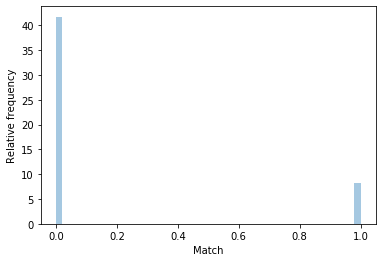

In [23]:
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns

ax = sns.distplot(y.astype(int), kde=False, norm_hist=True)
ax.set(xlabel='Match', ylabel='Relative frequency')

The humans in our dataset are a choosy bunch. A lot more non-matches than matches. It is probably worth resampling to get a more balanced distribution of the two classes. We finish off our pipeline by choosing the Balanced Random Forest classifier from the imbalanced learn package.

Alternatively, we could have used the AdaSyn resampling strategy and add it to our pipeline. We have to use the pipeline implementation by imblearn, because the Sampling is incompatible with sklearn transformers - the imbalanced learn module uses different methods in the transformers such as *fit_resample()*. Talking about different pipeline implementations, the dask package has its own pipeline as well, which is compatible with dask objects.

In [0]:
from imblearn.ensemble import (
    BalancedRandomForestClassifier,
    RUSBoostClassifier,
    BalancedBaggingClassifier
)
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

def create_model(n_estimators=20):
    return Pipeline(
        steps=[('preprocessor', preprocessor),
              ('imputation', imputer),
              ('rf', BalancedBaggingClassifier(
                  n_estimators=n_estimators,
                  base_estimator=RandomForestClassifier()
                  ))]
    )

Now we split training and test, and try it out!


In [0]:
from sklearn.model_selection import train_test_split

y = y.astype(int)
X_train, X_test, y_train, y_test = train_test_split(
   X , y, test_size=0.33, random_state=42, stratify=y
)

In [26]:
from sklearn.metrics import roc_auc_score, confusion_matrix

performances = []
for n_estimators in [20, 50, 100, 200, 500]:
    resampling_pipeline_bclf = create_model(n_estimators)
    resampling_pipeline_bclf.fit(X_train, y_train)
    y_predicted = resampling_pipeline_bclf.predict(X_test)
    auc = roc_auc_score(y_test, y_predicted)
    print('auc: {}'.format(auc))
    performances.append(auc)
    #confusion_matrix(y_test, y_predicted, labels=[0, 1])

/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change fr

auc: 0.7761738261738261


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change fr

auc: 0.7794538794538795


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change fr

auc: 0.7750416250416252


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change fr

auc: 0.7792207792207793


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change fr

auc: 0.7789876789876791


In [30]:
print(performances)

[0.7761738261738261, 0.7794538794538795, 0.7750416250416252, 0.7792207792207793, 0.7789876789876791]


In [0]:
y_predicted = resampling_pipeline_bclf.predict(X_test)

In [28]:
from sklearn.metrics import roc_auc_score, confusion_matrix
print('auc: {}'.format(roc_auc_score(y_test, y_predicted))
confusion_matrix(y_test, y_predicted, labels=[0, 1])

SyntaxError: ignored

In [0]:
confusion_matrix(y_test, y_predicted, labels=[0, 1])

Let us submit this to the OpenML leaderboard.

You can find the task number given the Speed Dating dataset id.


In [0]:
tasks = openml.tasks.list_tasks(data_id=40536, output_format='dataframe')
tasks.head()

In [0]:
from openml.extensions.sklearn import SklearnExtension

In [0]:
extension = SklearnExtension()
flow = extension._serialize_model(resampling_pipeline_brf)

In [0]:
# https://www.openml.org/t/146607
task = openml.tasks.get_task(125966)  # 125966, 146607
# Run the scikit-learn model on the task.
run = openml.runs.run_flow_on_task(flow, task)
# Publish the experiment on OpenML (optional, requires an API key.
# You can get your own API key by signing up to OpenML.org)
run.publish()
print(f'View the run online: {openml.config.server}/run/{run.run_id}')


In [0]:
model_package_name = resampling_pipeline_brf.__module__.split('.')[0]

In [0]:
model_package_name

In [0]:
import importlib

In [0]:
module = importlib.import_module(model_package_name)

In [0]:
module.__version__

In [0]:
This should get us to the top of the leaderboard on OpenML. 0.9735597735597736 ADASYN

In [0]:
ce.__version__

In [0]:
import imblearn
imblearn.__version__

In [0]:
module = importlib.import_module(BalancedRandomForestClassifier().__module__)

In [0]:
if '__version__' in module.__dict__ else 1.0

In [0]:
module.__version__

In [0]:
pip install git+https://github.com/marcotcr/lime

In [0]:
import nuymp

In [0]:
pd.__version__

In [0]:
import importlib

In [0]:
importlib.reload(lime)

In [0]:
explainer = lime.lime_tabular.LimeTabularExplainer(data, feature_names=list(data.columns), class_names=['no match', 'match'], discretize_continuous=True)


In [0]:
from lime. import LimeTextExplainer
explainer = LimeTextExplainer(class_names=['no match', 'match'])

In [0]:
exp = lime.lime_base.LimeBase.explain_instance_with_data(data.loc[0], resampling_pipeline_brf.predict_proba, num_features=6)

In [0]:
exp.as_list()